<a href="https://colab.research.google.com/github/heejvely/third-project/blob/main/T5_%EB%AA%A8%EB%8D%B8_%EC%BD%94%EB%93%9C_%EA%B0%95%EC%9D%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 url : https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb

# Mount 및 버전에 맞는 모듈 패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 버전에 맞는 패키지 설치
!pip install transformers==4.12.5
!pip install sentencepiece==0.1.91

     |████████████████████████████████| 3.1 MB 13.1 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 3.3 MB 81.8 MB/s 
     |████████████████████████████████| 61 kB 663 kB/s 
     |████████████████████████████████| 895 kB 67.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 12.6 MB/s 


# ET5, MT5 모델 사용 시

In [ ]:
# 모델 학습에 필요한 모듈 불러오기
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


# 모델 패스 지정
etri = '/content/drive/MyDrive/colab/3차/etri_et5' # 다운 받은 et5 모델 설정
mt5 = 'google/mt5-small' # hugging face path 지정, mt5는 환경상 small model밖에 작동되지 않음.

model = T5ForConditionalGeneration.from_pretrained(mt5)
tokenizer = T5Tokenizer.from_pretrained(mt5)

# KE-T5 모델 사용 시

In [ ]:
# KE-T5 model git clone
!git clone https://github.com/AIRC-KETI/ke-t5.git

In [ ]:
# change directory
%cd /content/ke-t5

In [ ]:
# model.generate(pieces)
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader


ke-t5-base = 'KETI-AIR/ke-t5-base'
ke-t5-small = 'KETI-AIR/ke-t5-small'

model = T5ForConditionalGeneration.from_pretrained(model_folder)
tokenizer = T5Tokenizer.from_pretrained(model_folder)

# GPU 환경 설정 및 사용자 함수 정의

In [ ]:
# gpu 환경 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# gpu 환경 적용
model.to(device)

In [ ]:
# model에 넣기 위한 형식으로 dataset 변경
class CustomDataset:

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        # batch_encode_plus: 인코딩된 sequences 쌍의 추가 정보를 포함하여 사전의 index 반환
        """
        [tokenizer.batch_encode_plus]
        encode_plus => single,   
        batch_encode_plus => a list of pairs of sequences
        
        < example >
            input_text = ['첫번째 문장', '두번째 문장']
            
            [input]
                tokenizer.encode_plus(input_text)
            [output]
                {'input_ids': [2, 2, 1], 
                 'attention_mask': [1, 1, 1]}

            [input]
                tokenizer.batch_encode_plus(input_text)
            [output]
                {'input_ids': [[21437, 19862, 1], [17521, 19862, 1]], 
                 'attention_mask': [[1, 1, 1], [1, 1, 1]]}
           """

        # input_ids: 문장을 토크나이즈해서 인덱스값으로 변환
        # attention_mask: 패딩된 부분에 대해 학습에 영향을 받지 않기 위해 처리해주는 입력값
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()
        # Tensor.squeeze() => 차원이 1인 차원 제거

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
            }
            # torch.long => 64비트의 부호있는 정수(64-bit integer (signed))
            

In [ ]:
# model fine-tuning task를 위한 사용자 함수
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in tqdm(enumerate(loader, 0)):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        if _%10 == 0:
            pass
            
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()

        """
        gradient를 0으로 설정
        이 작업을 하지 않을 시 학습중 backward를 해줄 때 계속 반영되어 예기치않은 방향으로 학습할 수 있음
        
        """
        loss.backward()  # 역전파 단계
        optimizer.step() # update hyper-parameters to optimizer
       

In [ ]:
# fine-tuning model이 test 진행을 하기 위한 사용자 함수
def test(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            # train과 다르게 generate할 수 있는 코드가 포함됨.
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

# hyper-parameters 설정

In [ ]:
# hyper parameter 설정
config = T5Config()
config.MAX_LEN = 1024
config.SUMMARY_LEN = 150 
config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64) , mt5-small, ke-t5 small은 batch_size 4까지 가능
config.TEST_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 12        # number of epochs to train (default: 10)
config.TEST_EPOCHS = 1 
config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)

In [ ]:
# hyper parameter train, valid에 적용
train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

test_params = {
        'batch_size': config.TEST_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

In [ ]:
# train, test dataset 설정
import pandas as pd
train_dataset = pd.read_csv('/content/drive/MyDrive/3차 프로젝트/dataset/train.csv')[['document','label']]
test_dataset = pd.read_csv('/content/drive/MyDrive/3차 프로젝트/dataset/test.csv')[['document','label']]

# train(Fine-tuning)

"Note that the choice of text prefix used for a given task is essentially a hyperparameter"

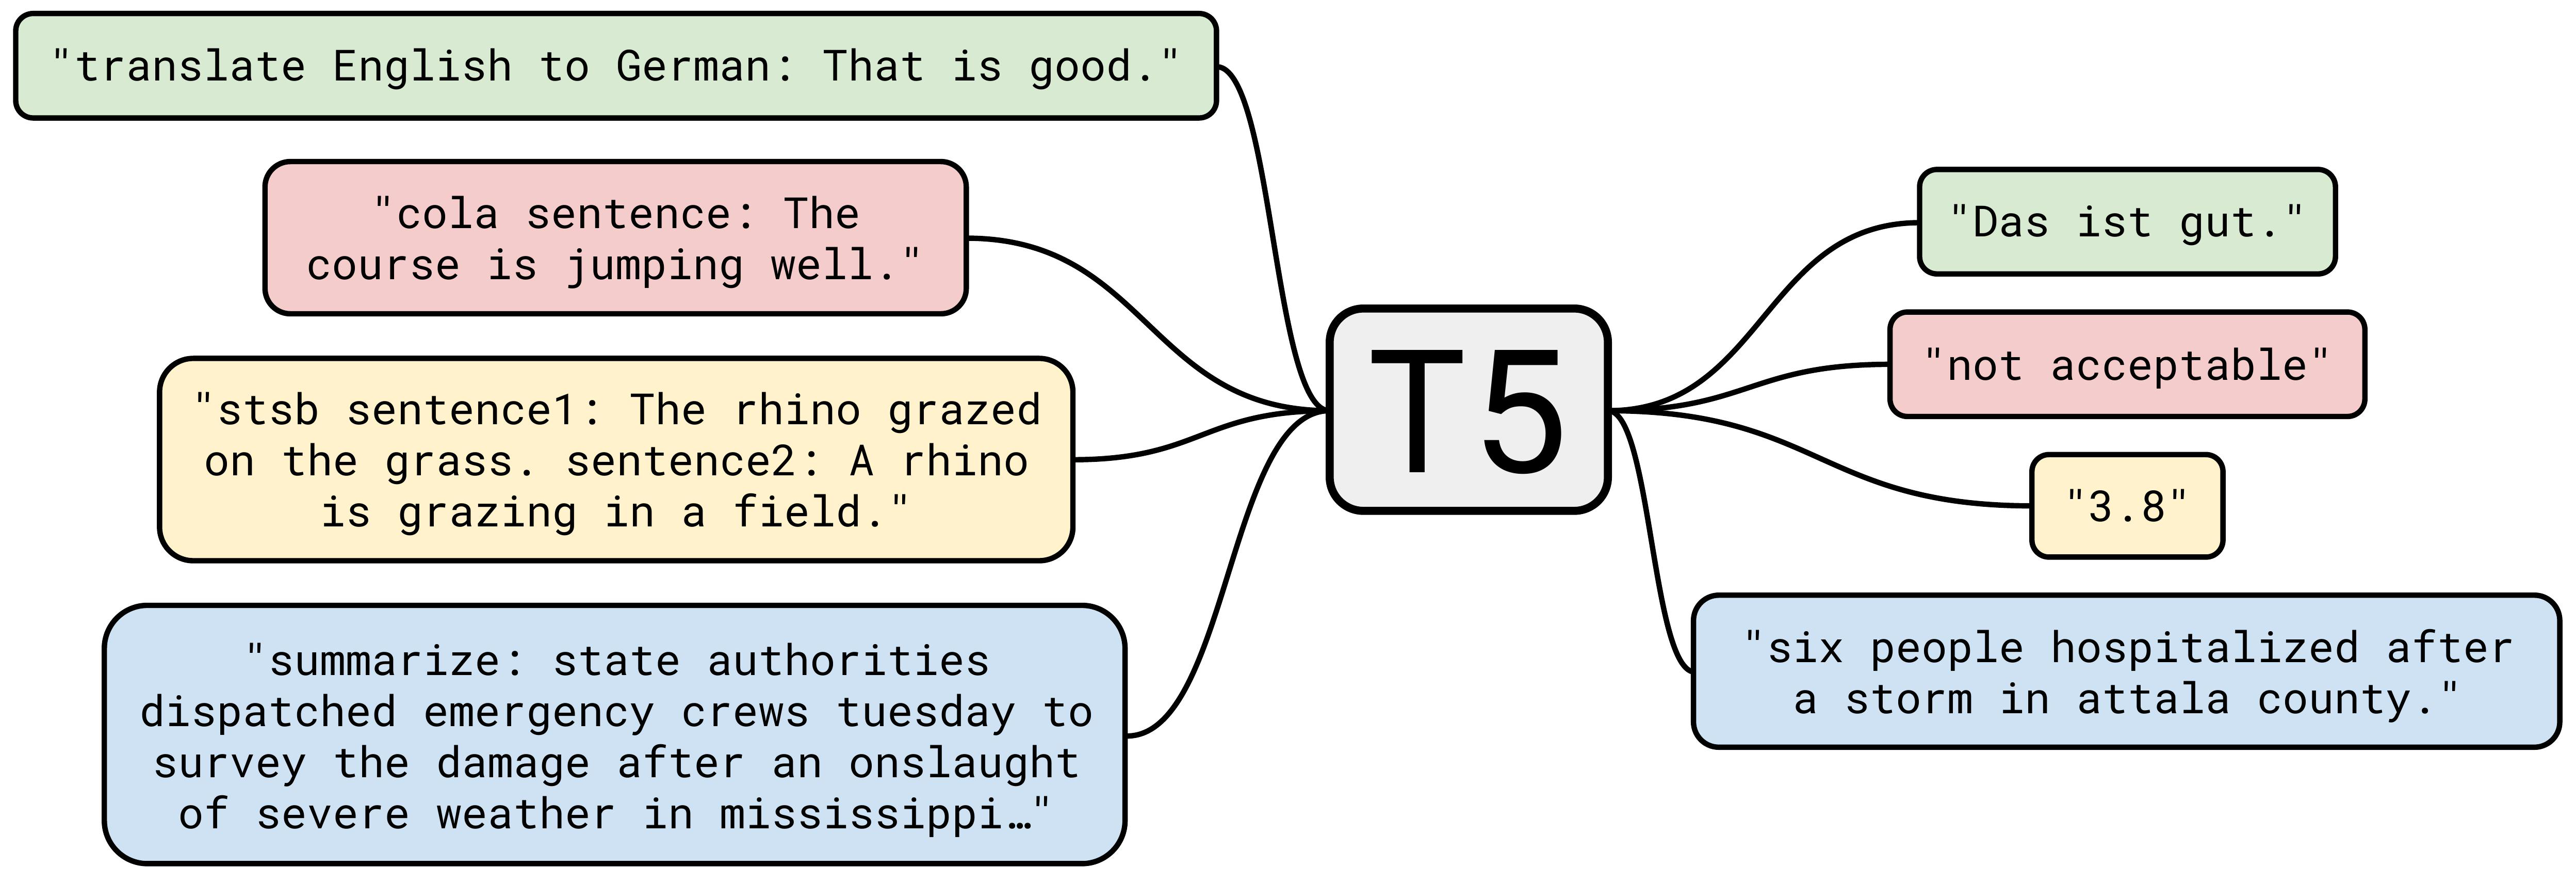

## T5 architecture

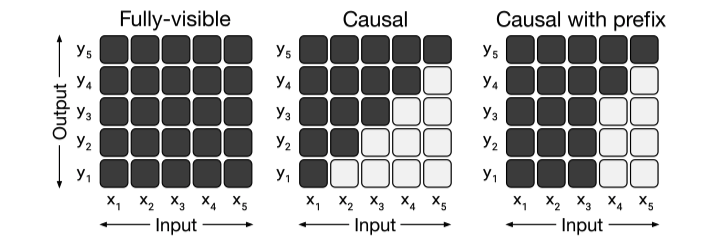
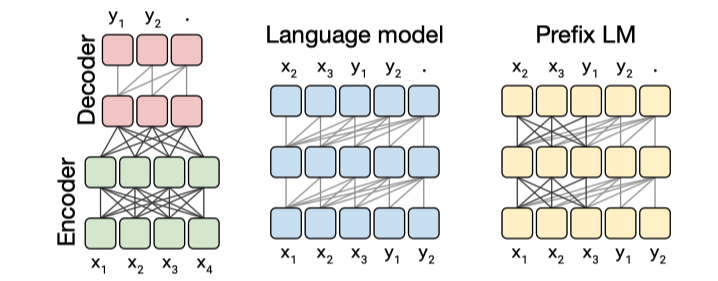

In [ ]:
# fine-tuning 진행
# 모델이 학습하기 위한 columns name 변경 (ctext: 원문, text: 요약문)
train_dataset.columns = ['ctext','text']

# t5는 prefix 모델로써, 진행할 task를 입력할 시 해당 task 진행
# summarize 진행 할 예정으로 summarize 추가
train_dataset.ctext = 'summarize: ' + train_dataset.ctext

# 위에서 정의한 model에 맞는 dataset 형식 변경하는 함수 적용
training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

# DataLoader : 일일히 모든 데이터를 나눠서 forward, backward 작업을 해야하는데 그 과정을 대신 해주는 과정
# 학습 시 minibatch, epoch마다 데이터를 다시 섞어 과적합을 막음.
training_loader = DataLoader(training_set, **train_params) # **var -> {key:value} 형식으로 반환

for epoch in range(config.TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)

# test

In [ ]:
test_dataset.columns = ['ctext','text']
test_dataset.ctext = 'summarize: ' + test_dataset.ctext

test_set = CustomDataset(test_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

test_loader = DataLoader(test_set, **test_params)

for epoch in range(config.TEST_EPOCHS):
    predictions, actuals = test(epoch, tokenizer, model, device, test_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})

final_df

In [ ]:
# bert_score 평가 위한 dataframe 저장
final_df.to_csv('/content/drive/MyDrive/3차 프로젝트/dataset/eval.csv')

In [ ]:
# model, tokenizer 저장
tokenizer.save_pretrained('/content/drive/MyDrive/3차 프로젝트/first_training')
model.save_pretrained('/content/drive/MyDrive/3차 프로젝트/first_training')

# 추가 학습

In [ ]:
# 모델 학습에 필요한 모듈 불러오기
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


# 모델 패스 지정
model_path = '/content/drive/MyDrive/3차 프로젝트/first_training'

model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

## model path를 처음 학습 시킨 모델러 지정 후 다시 학습 과정 진행

# BERT Score

코드 출처

https://github.com/Tiiiger/bert_score

In [42]:
# BERT Score 모듈 install

!pip install bert-score

In [12]:
# tokenizer를 위한 sentencepiece 설치
!pip install sentencepiece

In [13]:
# bert-score 옵션
!bert-score -h

usage: Calculate BERTScore [-h] [--lang LANG] [-m MODEL] [-l NUM_LAYERS]
                           [-b BATCH_SIZE] [--nthreads NTHREADS] [--idf]
                           [--rescale_with_baseline]
                           [--baseline_path BASELINE_PATH]
                           [--use_fast_tokenizer] [-s] [-v] -r REF [REF ...]
                           -c CAND

optional arguments:
  -h, --help            show this help message and exit
  --lang LANG           two-letter abbreviation of the language (e.g., en) or
                        "en-sci" for scientific text
  -m MODEL, --model MODEL
                        BERT model name (default: bert-base-uncased) or path
                        to a pretrain model
  -l NUM_LAYERS, --num_layers NUM_LAYERS
                        use first N layer in BERT (default: 8)
  -b BATCH_SIZE, --batch_size BATCH_SIZE
                        batch size (default: 64)
  --nthreads NTHREADS   number of cpu workers (default: 4)
  --idf               

In [17]:
%cd /content/drive/MyDrive/colab/3차

/content/drive/MyDrive/colab/3차


In [40]:
import pandas as pd
pd.read_table('/content/drive/MyDrive/colab/3차/document.txt')

,"▲ '제3회 만천하스카이워크배 전국오픈 탁구대회'가 9~10일 단양국민체육센터에서 열렸다.단양군 제공▲ 조성룡 단양군의원이 추첨에 당첨된 수도권 탁구 선수에게 단양마늘을 전달하고 있다.단양군 제공▲ '제3회 만천하스카이워크배 전국오픈 탁구대회' 단체전 상위부 우승을 차지한 부평랜드팀 이금소·전승호· 송재현·이도현.단양군 제공[충청투데이 이상복 기자] '탁구의 메카' 충북 단양군에서 탁구인들이 그동안 갈고닦은 자웅을 겨루는 '제3회 만천하스카이워크배 전국오픈 탁구대회'가 열렸다.9~10일 이틀간 단양국민체육센터에서 열린 이번 대회에는 이정규 단양군탁구협회장과 박형채 전무이사, 김은영·한석준 총무이사, 김동운·황상준 경기이사, 이영식 섭외이사 등의 진행으로 전국 탁구동호인 600여명이 참석한 가운데 성황리 개최됐다.탁구인들의 잔치를 축제로 만들기 위한 조치로 단양군탁구협회는 개회식을 개최하지 않은 가운데 단양마늘, 단양 수수, 단양아로니아 비타, 단양아로니아 파우치, 단양사과, 단양 고추장 등 단양 농특산물을 경품과 증정품으로 내놓았다.특히 조성룡 단양군의회 군의원이 경품을 추첨해 단양마늘과 단양 사과를 전달해 경품에 당첨된 탁구인의 환호와 축하에 박수가 쏟아졌다.이어 최원형 단양군 체육회 사무국장의 추첨으로 5명의 경품 당첨자들이 사과와 단양마늘을 경품으로 받았다.화창한 날씨 속에 전국에서 참여한 선수들은 박진감 넘치고 수준 높은 경기력을 선보였다.또 선수들과 탁구협회, 진행팀들은 페어플레이와 깔끔한 경기 진행이 돋보였다는 평가를 받았다.이정규 단양군탁구협회 회장은 ""꿈과 희망이 있는 살기좋은 단양에서 전국 탁구인들을 모시고 '제3회 단양 만천하스카이워크배 전국오픈탁구대회'를 개최하게 된 것을 매우 기쁘게 생각한다""며 ""이번 대회를 통해 체력단련을 통한 건강을 챙기고, 스트레스 해소 등 그동안 갈고닦은 실력을 맘껏 발휘하고, 우정과 친목을 도모하는 화합의 장이 되시길 바란다""고 격려했다.지난 9일 첫날 도담부와 석문부, 삼봉부 라지볼로 시작한 이날 대회는 복식과 단체전으로 예선전과 결승까지 진행했다.또 일반부 대회에서는 온달부 상위부와 하위부가 본선을 치르며 자웅을 겨뤘다.평강부도 상·하위부로 나눠 실력을 겨뤘다.이어 열린 둘째 날에는 일반부 단체전 혼성4 단체전(단·복·단) 온달부(선수부·챔피언부, 전국 1·2·3부로 구성)가 상위부와 하위부로 나눠 본선을 치르며 실력을 겨뤘다.온달부(선-3) 단체전 우승은 부평랜드가 차지해 상장과 상금 70만원을 수상했고, 준우승은 다마스버터플라이코리 팀이 차지해 상장과 상금 50만원, 3위는 다마스버터플라이코리 팀·티밸런스 팀이 차지해 상장과 상금 30만원씩을 각각 받았다.평강부(3-7) 단체전 우승은 이필영클럽 팀이 차지해 상장과 상금 70만원 차지했고, 준우승은 탑탁구클럽 팀이 차지해 상장과 상금 50만원, 3위는 이태영탁구교실·의정부드림 팀이 차지해 30만원을 각각 수상했다.류한우 단양군수는 ""제3 단양만천하스카이워크배 전국 오픈 탁구대회가 성황리에 개최돼 매우 뜻깊다""며 ""선수 간 우애와 친목을 다지는 대회로 대한민국 탁구가 더욱 발전하고 저변을 넓혀 나가길 기원한다""고 말했다."
0,서울시가 미세먼지 저감을 위해 시행 중인 차량운행제한 정책의 실효성을 높이기 위해 ...
1,최근 제주도내 해수욕장에 상어가 나타나면서 제주특별자치도가 상어퇴치기 설치를 적극 ...
2,신기호 기자최근 자유한국당 홍준표 전 대표가 문희상 국회의장이 정치세습을 한다고 주...
3,삼성SDS가 중국 스마트시티·클라우드·스마트물류 시장 개척에 본격적으로 나선다.삼성...
4,"백세종전주시 '다함께 차차차' 포장마차 거리 개장21일 개장식, 올 연말까지 매주 ..."
...,...
9994,김준(앞줄 왼쪽) SK이노베이션 총괄사장이 지난 10일 미국 라스베이거스에서 개최된...
9995,'상상 커리어다이닝' 참가자 모집▲ 상상 커리어다이닝 참가자 모집 포스터.KT&G ...
9996,지난 27일 방송된 SBS ‘백종원의 골목식당’이 평균 시청률 1부 6.7% 2부 ...
9997,"제주신보송상열, 한의사·한의학 박사어제는 대학 입시의 최대 관문인 수학능력 시험이 ..."


In [37]:
pd.read_csv('/content/drive/MyDrive/colab/3차/generated_et5_290000_epoch12.txt')

,"단양군 탁구협회 회장, 전무이사, 경기이사 등 탁구동호인 600여명이 참석한 가운데 9~10일 이틀간 단양국민체육센터에서 열린 '제3회 만천하스카이워크배 전국오픈 탁구대회'에서 류한우 단양군수는 ""선수 간 우애와 친목을 다지는 대회로 매우 뜻깊다""고 말했다"
0,지 서울시 에너지시민협력과장은 미세먼지 저감을 위해 시행 중인 차량운행제한 정책의 ...
1,"은 아니지만 공격성이 높지 않다는 종류로 보이는 상어가 나타나자, 제주도는 상어퇴치..."
2,홍준표 전 대표는 지난달 30일 문희상 의장이 패스트트랙 법안을 본회의에 부의하려는...
3,"영업과 사업수행을 맡아 중국 내 스마트시티, 클라우드, 스마트물류 등의 사업분야에서..."
4,의 장소로 사랑을 받아왔던 전주신중앙시장을 다시 조성하기 위해 21일 '추억의 포장...
...,...
9994,SK이노베이션이 지난해 4·4분기부터 '그룹 통합 채용사이트(skcareers.co...
9995,&G는 25일 다음달 7일까지 취업을 준비하는 2~4학년 대학생 150명을 대상으로...
9996,이 위기를 맞으며 지역 상권도 악영향을 받고 있는 '거제도' 첫 편을 지난 27일 ...
9997,"의 우황은 심열로 인한 불안, 혼미 등 정신적 이상 그리고 간열로 인한 근육 마비나..."


-r: BERT Score를 위한 참조 파일(txt 형태)

-c: BERT Score를 내기 위한 파일(txt 형태)

-m: vector 값 계산할 model path 지정(default: m-bert)

단, m-bert를 사용할 시 --lang을 ko로 옵션을 줘야함.

-l: layer 갯수를 몇개 사용할지 지정(koelectra 기본 layer인 12개 사용)

-- use_fast_tokenize: hugging_face의 tokenizer를 쓰겠다고 입력하는 옵션(hugging_face model 및 tokenizer를 쓸 경우 필수로 적용해줘야함)

In [41]:
# epoch 15, et5
!bert-score -r document.txt -c generated_et5_290000_epoch12.txt -m 'monologg/koelectra-base-v2-discriminator' -l 12 --use_fast_tokenize

Some weights of the model checkpoint at monologg/koelectra-base-v2-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
monologg/koelectra-base-v2-discriminator_L12_no-idf_version=0.3.11(hug_trans=4.12.5) P: 0.915634 R: 0.863756 F1: 0.888880
